In [15]:
import jax
import jax.numpy as jnp
from typing import Any
from flax import linen as nn
from jax import random, grad, vmap, jit
from pikan.model_utils import gradf
import numpy as np
from functools import partial
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import optax

def animate_3d_array(data, cmap='jet', interval=50):
    fig, ax = plt.subplots()
    im = ax.imshow(data[:, :, 0], cmap=cmap, origin='lower', interpolation='nearest')
    plt.colorbar(im, ax=ax)

    def update(t):
        im.set_array(data[:, :, t])
        ax.set_title(f'Time step: {t}')
    
    anim = FuncAnimation(fig, update, frames=data.shape[2], interval=interval)
    
    plt.close(fig)  # Prevent static frame from showing
    
    # Return HTML representation of the animation for embedding in Jupyter
    return HTML(anim.to_jshtml())

def load_ns_data():
    data = np.load('ns_tori.npy', allow_pickle=True).item()

    for key in data.keys() - {"viscosity"}:
        data[key] = np.moveaxis(data[key], 0, -1)

    return data['u'], data['v'], data['w'], data['x'], data['y'], data['t']

In [25]:
class NS_torus():
    def __init__(self, model, u0, v0, w0, x_star, y_star):
        self.model = model
        self.RE = 100
        
        self.r_net_fn = vmap(self.r_net, (None, 0,0,0))
        self.neural_net_fn = vmap(self.neural_net, (None, 0,0,0))
        self.w_net_fn = vmap(self.w_net, (None, 0,0,0))
        
        self.u0 = u0.reshape(-1)
        self.v0 = v0.reshape(-1)
        self.w0 = w0.reshape(-1)
        
        self.x_star = x_star.reshape(-1)
        self.y_star = y_star.reshape(-1)
        
    def neural_net(self, params, x, y, t):
        collocs = jnp.stack([x,y,t])
        outputs = self.model.apply(params, collocs)

        u = outputs[0]
        v = outputs[1]
        return u, v

    def u_net(self, params, x, y, t):
        u, _ = self.neural_net(params,x,y,t)
        return u
    
    def v_net(self, params, x, y, t):
        _, v = self.neural_net(params, x,y,t)
        return v

    def w_net(self, params, x, y, t):
        v_x = grad(self.v_net, argnums=1)(params,x,y,t)
        u_y = grad(self.u_net, argnums=2)(params,x,y,t)
        
        return v_x + u_y
    
    def r_net(self, params, x, y, t):
        # w_t + U * grad w - 1/Re * Laplacian w
        w_t = grad(self.w_net, argnums=3)(params,x,y,t)
        w_x = grad(self.w_net, argnums=1)(params,x,y,t)
        w_y = grad(self.w_net, argnums=2)(params,x,y,t)
        
        u, v = self.neural_net(params, x, y, t)
        
        w_xx = grad(grad(self.w_net, argnums=1), argnums=1)(params,x,y,t)
        w_yy = grad(grad(self.w_net, argnums=2), argnums=2)(params,x,y,t)
        eq1 = w_t + (u*w_x + v*w_y) - 1/self.RE * (w_xx+w_yy)
        
        # u_x + v_y = 0 eq2
        u_x = grad(self.u_net, argnums=1)(params,x,y,t)
        v_y = grad(self.v_net, argnums=2)(params,x,y,t)
        eq2 = u_x + v_y
        
        return eq1, eq2
    
    @partial(jit, static_argnums=(0,))
    def loss(self, params, collocs): # collocs shape (BS, 3)
        t0 = jnp.zeros_like(self.x_star)
        u0,v0 = self.neural_net_fn(params, self.x_star, self.y_star, t0)
        w0 = self.w_net_fn(params, self.x_star, self.y_star, t0)
        
        u0_loss = jnp.mean((u0 - self.u0)**2)
        v0_loss = jnp.mean((v0 - self.v0)**2)
        w0_loss = jnp.mean((w0 - self.w0)**2)
        
        ic_loss = u0_loss + v0_loss + w0_loss
        
        eq1, eq2 = self.r_net_fn(params, collocs[:, 0], collocs[:, 1], collocs[:, 2])
        res_loss = jnp.mean(eq1**2) + jnp.mean(eq2**2)
        
        new_loc_w = None
        return res_loss + ic_loss, new_loc_w

In [26]:
from pikan.model_utils import GeneralizedMLP, FourierFeats

model = GeneralizedMLP(
    kernel_init=nn.initializers.glorot_normal(),
    num_input=3,
    num_output=1,
    layer_sizes=[64,64,64] # first is fourier
)

dp = jnp.ones(3)
params = model.init(random.PRNGKey(0), dp)
model

GeneralizedMLP(
    # attributes
    kernel_init = init
    num_input = 3
    num_output = 1
    use_fourier_feats = False
    layer_sizes = [64, 64, 64]
)

In [27]:
u,v,w,x,y,t = load_ns_data()
x_star, y_star = jnp.meshgrid(x, y)

In [28]:
ns_torus = NS_torus(
    model, 
    u[:, :, 0], v[:, :, 0], w[:, :, 0],
    x_star, y_star,
)

BS = 32
collocs = jnp.ones((BS, 3))
ns_torus.loss(params, collocs)

(Array(14.078417, dtype=float32), None)

In [29]:
EPOCHS = 10000

# Define a cosine decay learning rate schedule
schedule_fn = optax.cosine_decay_schedule(
    init_value=1e-2,       # Initial learning rate
    decay_steps=EPOCHS,  # Total number of decay steps
    alpha=1e-3             # Final learning rate multiplier
)

optimizer = optax.adamw(learning_rate=schedule_fn, weight_decay=1e-4)
opt_state = optimizer.init(params)

In [30]:
from pikan.model_utils import sobol_sample
from tqdm import tqdm 

BS = 1024
# x,y,t
collocs = sobol_sample(np.array([0,0,0]), np.array([2*np.pi, 2*np.pi, 1]), BS)
collocs.shape

(1024, 3)

In [ ]:
import jax
import optax

# Define your gradient function
grad_fn = jax.value_and_grad(ns_torus.loss, has_aux=True)

# Define the training loop
def train_step(params, collocs, opt_state):
    # Compute loss and gradients
    (loss, new_loc_w), grads = grad_fn(params, collocs)

    # Apply gradients to update the parameters
    updates, opt_state = optimizer.update(grads, opt_state, params)
    params = optax.apply_updates(params, updates)
    
    return params, opt_state, loss

BS = 2048
collocs = sobol_sample(np.array([0,0,0]), np.array([2*np.pi, 2*np.pi, 1]), BS)

for i in (pbar:= tqdm(range(EPOCHS))):
    params, opt_state, loss = train_step(params, collocs, opt_state)

    if i % 50 == 0: # dont waste a lot of time printing
        pbar.set_description(f"Loss {loss: .8f}")

Loss  7.93070412:  14%|█▎        | 1372/10000 [04:23<26:02,  5.52it/s]

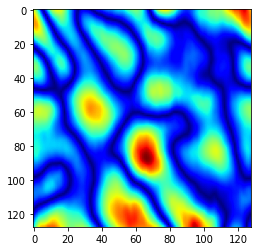

In [9]:
(u,v) = ns_torus.neural_net_fn(params, ns_torus.x_star, ns_torus.y_star, jnp.zeros_like(ns_torus.x_star))

normflow = np.sqrt(u**2 + v**2).reshape((128, 128))
plt.imshow(normflow, cmap="jet")

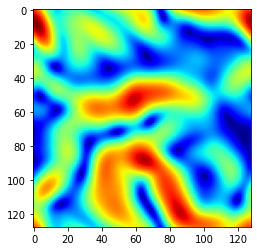

In [10]:
normflow = np.sqrt(ns_torus.u0**2 + ns_torus.v0**2).reshape((128, 128))
plt.imshow(normflow, cmap="jet")

In [11]:
import jax.numpy as jnp

u, v, w, x, y, t = load_ns_data()

x_star, y_star, t_star = jnp.meshgrid(x, y, t, indexing='ij')
# Filter points where t_star < 1
mask = t_star < 1
x_filtered = x_star[mask]
y_filtered = y_star[mask]
t_filtered = t_star[mask]
u.shape

(128, 128, 201)

In [12]:
u = u[:, :, t<1]
v = v[:, :, t<1]

normflow = np.sqrt(u**2 + v**2)
animate_3d_array(normflow, interval=100)

In [13]:
(u_hat,v_hat) = ns_torus.neural_net_fn(params, x_filtered, y_filtered, t_filtered)
u_hat = u_hat.reshape(128, 128, -1)
v_hat = v_hat.reshape(128, 128, -1)

normflow = np.sqrt(u_hat**2 + v_hat**2)
animate_3d_array(normflow, interval=200)

In [ ]:
collocs.shape